# Autoencoders
- Generative Model
- *Description* - Compresses the data (Encoding) into a lower dimensional data, which can then be decoded back to its original state without much loss of information

- Recreate the model
- Loss used: **Mean Squared Error**

When creating this encoding
- If we use `nn.Linear` in **encoding**, then we will use `nn.Linear` only for the **decoding** process
- If we use `nn.Conv2d` in **encoding**, then we will use `nn.ConvTranspose2d` for the **decoding** process (For Convolution operations)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchsummary import summary
import copy

In [2]:
device = torch.device('mps')
device

device(type='mps')

In [3]:
transform = transforms.ToTensor()
mnist_data = datasets.MNIST(
    root = '../datasets',
    train = True,
    download = True,
    transform = transform
)
data_loader = torch.utils.data.DataLoader(
    dataset = mnist_data,
    batch_size = 64,
    shuffle = True
)

In [4]:
dataiter = iter(data_loader)
images, labels = dataiter.next()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [5]:
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # (N, 784) -> (N, 128)
            nn.ReLU(), 
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 10) # -> N, 3
        )

        # With non-linear activations performance is BETTER than with just linear activations (g(x) = x)
        
        self.decoder = nn.Sequential(
            nn.Linear(10, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return(self.encoder(x))
    
    def decode(self, x):
        return(self.decoder(x))
# Note: [-1, 1] -> Tanh function
# Can be achieved by using transforms.Normalize((0.5),(0.5)), and then use TanH instead of Sigmoid in decoder function

In [6]:
model = Autoencoder_Linear().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-6)

In [7]:
summary(copy.deepcopy(model).to('cpu'), (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]         100,480
              ReLU-2               [-1, 1, 128]               0
            Linear-3                [-1, 1, 64]           8,256
              ReLU-4                [-1, 1, 64]               0
            Linear-5                [-1, 1, 12]             780
              ReLU-6                [-1, 1, 12]               0
            Linear-7                [-1, 1, 10]             130
            Linear-8                [-1, 1, 12]             132
              ReLU-9                [-1, 1, 12]               0
           Linear-10                [-1, 1, 64]             832
             ReLU-11                [-1, 1, 64]               0
           Linear-12               [-1, 1, 128]           8,320
             ReLU-13               [-1, 1, 128]               0
           Linear-14               [-1,

In [8]:
# Point to training loop video
num_epochs = 20
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        img = img.to(device)
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0456
Epoch:2, Loss:0.0433
Epoch:3, Loss:0.0346
Epoch:4, Loss:0.0295
Epoch:5, Loss:0.0246
Epoch:6, Loss:0.0315
Epoch:7, Loss:0.0241
Epoch:8, Loss:0.0248
Epoch:9, Loss:0.0258
Epoch:10, Loss:0.0197
Epoch:11, Loss:0.0246
Epoch:12, Loss:0.0247
Epoch:13, Loss:0.0230
Epoch:14, Loss:0.0235
Epoch:15, Loss:0.0194
Epoch:16, Loss:0.0195
Epoch:17, Loss:0.0218
Epoch:18, Loss:0.0203
Epoch:19, Loss:0.0184
Epoch:20, Loss:0.0182


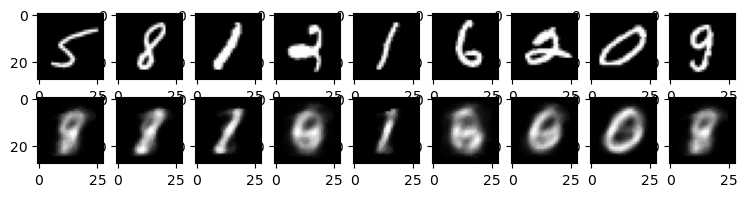

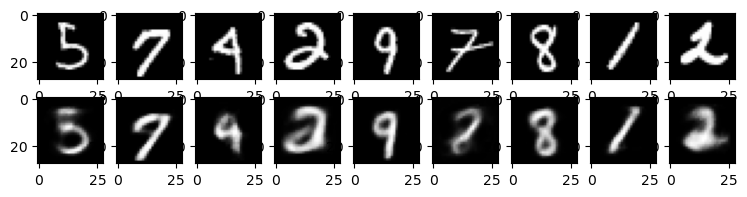

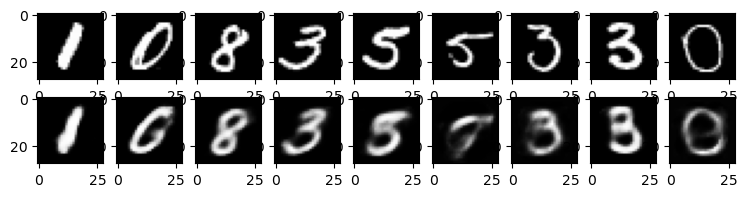

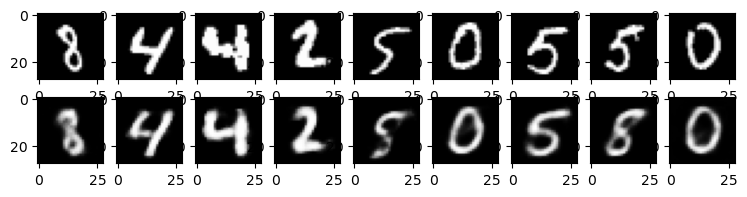

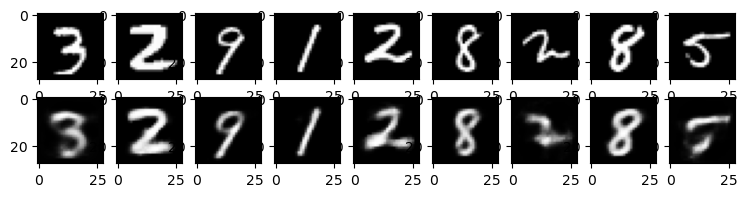

In [9]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

In [8]:
class Autoencoder(nn.Module):
    def __init__(self) -> None:
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16,3,1,1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16,16,3,1,1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16,16,3,2,1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16,32,3,1,1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,32,3,1,1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,32,3,2,1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,64,5,1,0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,3,1,0),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Flatten(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 10)
        )

        # Batch Norm increases performance by a big amount
        
        self.decoder = nn.Sequential(
            # nn.BatchNorm2d(64),
            nn.Linear(10, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.Unflatten(dim = 1, unflattened_size=(64,1,1)),
            nn.ReLU(),
            nn.ConvTranspose2d(64,64,3,1,0),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64,32,5,1,0),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32,32,3,2,1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32,32,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32,16,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16,16,3,2,1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16,16,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16,1,3,1,1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return(decoded)
    
    def encode(self, x):
        return(self.encoder(x))
    
    def decode(self, x):
        return(self.decoder(x))
    

In [9]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-7)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 4, gamma = 0.4)

In [29]:
summary(copy.deepcopy(model).to('cpu'), (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 16, 28, 28]           2,320
              ReLU-4           [-1, 16, 28, 28]               0
            Conv2d-5           [-1, 16, 14, 14]           2,320
              ReLU-6           [-1, 16, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           4,640
              ReLU-8           [-1, 32, 14, 14]               0
            Conv2d-9           [-1, 32, 14, 14]           9,248
             ReLU-10           [-1, 32, 14, 14]               0
           Conv2d-11             [-1, 32, 7, 7]           9,248
             ReLU-12             [-1, 32, 7, 7]               0
           Conv2d-13             [-1, 64, 3, 3]          51,264
             ReLU-14             [-1, 6

In [10]:
num_epochs = 20
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        img = img.to(device)
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}, LR = {scheduler.get_last_lr()[0]}')
    scheduler.step()
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0289, LR = 0.001
Epoch:2, Loss:0.0271, LR = 0.001
Epoch:3, Loss:0.0236, LR = 0.001
Epoch:4, Loss:0.0232, LR = 0.001
Epoch:5, Loss:0.0219, LR = 0.0004
Epoch:6, Loss:0.0184, LR = 0.0004
Epoch:7, Loss:0.0210, LR = 0.0004
Epoch:8, Loss:0.0189, LR = 0.0004
Epoch:9, Loss:0.0193, LR = 0.00016
Epoch:10, Loss:0.0172, LR = 0.00016
Epoch:11, Loss:0.0158, LR = 0.00016
Epoch:12, Loss:0.0199, LR = 0.00016
Epoch:13, Loss:0.0170, LR = 6.400000000000001e-05
Epoch:14, Loss:0.0137, LR = 6.400000000000001e-05
Epoch:15, Loss:0.0184, LR = 6.400000000000001e-05
Epoch:16, Loss:0.0176, LR = 6.400000000000001e-05
Epoch:17, Loss:0.0192, LR = 2.5600000000000006e-05
Epoch:18, Loss:0.0163, LR = 2.5600000000000006e-05
Epoch:19, Loss:0.0177, LR = 2.5600000000000006e-05
Epoch:20, Loss:0.0224, LR = 2.5600000000000006e-05


In [ ]:
# torch.save(model, 'models/Autoencoder_MNIST.pt')

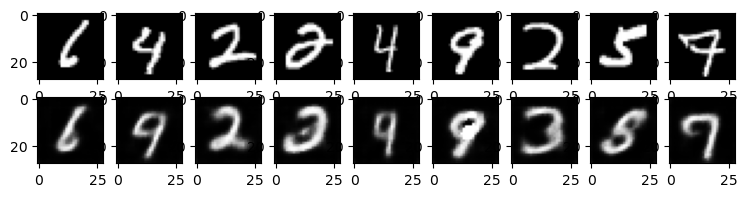

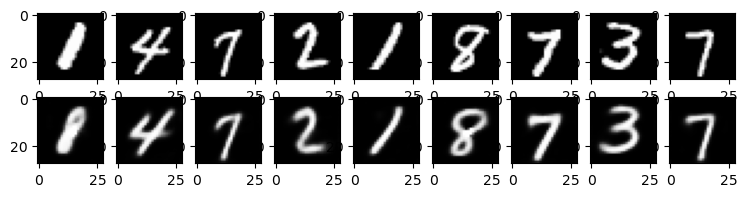

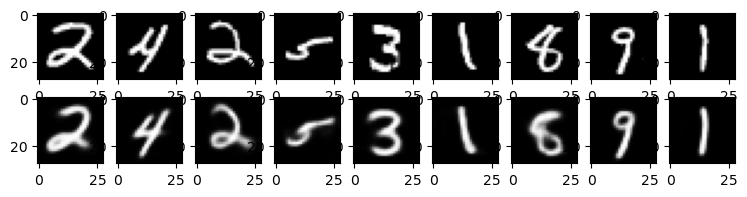

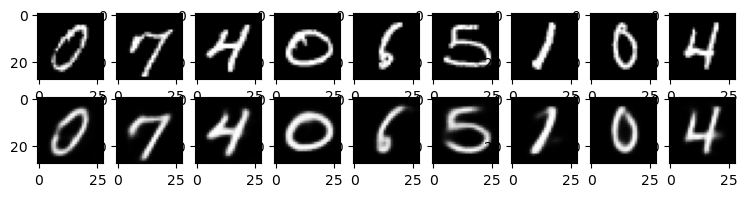

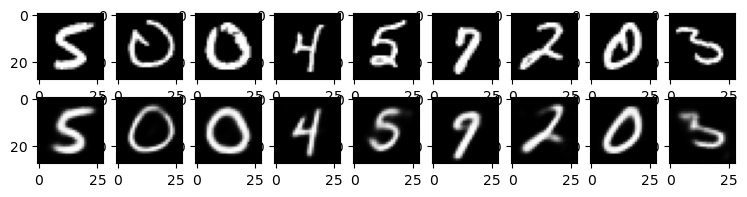

In [11]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])